# Scaling laws in image classification

The performance of an image classification algorithm depens on three factors:
* complexity of a model,
* the amount of training data,
* the amount of computational resources.

To achieve best performance one has to make a careful tradeoff between these aspects. 
Note that there are usually hard limits on the amount of training data and the amount of computational resources.
In this tutorial, we fix a model and computational resources and consider how does the performance change if we add more data.
The corresponding scaling law gives an insight what is needed to get a better performance. 

We are going to work with [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). 
Although the MNIST dataset is small we can still work out scaling laws. 
Later on we can improve the treatment and train an image generator on MNIST data that outputs potentially infinite dataset.

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from keras.optimizers import Adam
from plotnine import *

from convenience import display_source

##from model_library.display_code import display_source
##from model_library.dataframe_manipulation import combine_two_dataframes

## I. Dataset prepararion

We will use the MNIST dataset as is and evaluate classifiers that predict labels $0,\ldots,9$. 

**Training data**
* We use the entire training set: $N=60,000$.
* We use tensors with dimensions $(N)$ as labels.
* We use tensors with dimension $(N, 28, 28)$ as input images.

**Test data**
* We the entire test set: $N=10,000$.
* We use tensors with dimensions $(N)$ as labels.
* We use tensors with dimension $(N, 28, 28)$ as input images.

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist


# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

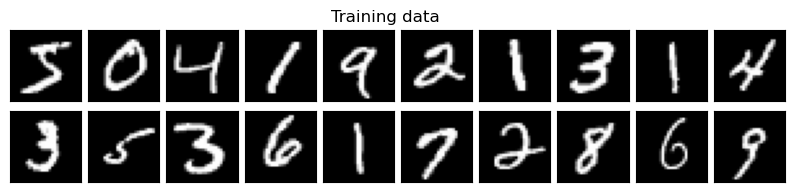

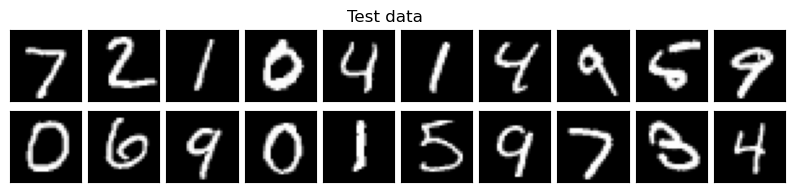

In [3]:
fig, axs = plt.subplots(2, 10, figsize=(10, 2))
plt.suptitle('Training data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(10):
    axs[0, i].imshow(train_images[i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].imshow(train_images[10 + i], cmap='gray', vmin=0, vmax=1)
plt.show()

fig, axs = plt.subplots(2, 10, figsize=(10, 2))
plt.suptitle('Test data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(10):
    axs[0, i].imshow(test_images[i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].imshow(test_images[10 + i], cmap='gray', vmin=0, vmax=1)
plt.show()

## II. Models to be trained 

We are going to consider two models implemented as `keras` neural networks:
* [Logistic regression model](https://en.wikipedia.org/wiki/Logistic_regression) -- a limited model that underfits the data;
* Convolutional neural network [Lenet5 by Yan Lecun](https://ieeexplore.ieee.org/document/726791) -- a rich model that is known to perform well on this data.

**Change model architecture**

* Differently from tutorial [01_scaling_laws_on_minst_data.ipynb]('./tutorials/data-scaling/01_scaling_laws_on_minst_data.ipynb') we need to change the last layer.
* We need to use `Dense(10, activation='softmax')` layer instead of current `Dense(1, activation='sigmoid')`.

In [4]:
import sys
sys.path.append('tutorials/data-scaling/')

from model_library.logreg import mnist_logreg_model
display_source(mnist_logreg_model)

from model_library.lenet5 import mnist_binary_lenet5_model
display_source(mnist_binary_lenet5_model)

```python
def mnist_logreg_model() -> keras.Model:
    """
    Returns initialised neural network for computing logistic regression on 28 x 28 greyscale images.
    """
    logreg = keras.Sequential(
        [
            layers.InputLayer((28, 28)),
            layers.Flatten(),
            layers.Dense(1, activation='sigmoid')
        ],
        name="Logistic_regression"
    )
    logreg.build()
    return logreg

```

```python
def mnist_binary_lenet5_model() -> keras.Model:
    """
    Returns initialised neural network for LeNet-5 model that works on 28 x 28 greyscale images.
    Differently form the original model we consider only separation of two digit classes.
    The model structure is adapted from Kaggle webpage LeNet-5 CNN with Keras
    https://www.kaggle.com/code/curiousprogrammer/lenet-5-cnn-with-keras-99-48
    """
    lenet5 = keras.Sequential(
        [
            layers.InputLayer((28, 28, 1)),
            layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
            layers.MaxPool2D(strides=2),
            layers.Conv2D(filters=48, kernel_size=(5, 5), padding='valid', activation='relu'),
            layers.MaxPool2D(strides=2),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(84, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ],
        name="LeNet-5"
    )
    lenet5.build()
    return lenet5

```

**Change label encoding** 

Secondly, we need to use one-hot-encoding for labels instead of values $0, \ldots, 9$.

In [5]:
from tensorflow.keras.utils import to_categorical

old_train_labels = train_labels[:20]
train_labels = to_categorical(train_labels, 10)
test_labels= to_categorical(test_labels, 10)

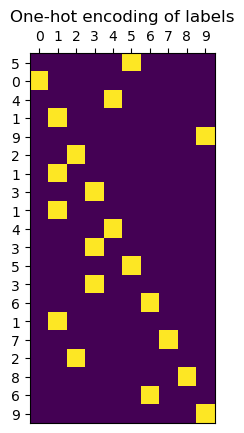

In [6]:
plt.title('One-hot encoding of labels')
plt.imshow(train_labels[:20])
plt.xticks(ticks=list(range(0,10)))
plt.gca().tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False)
plt.yticks(ticks = list(range(0, 20)), labels=old_train_labels )
plt.show()

**Change loss function and accuracy metric**

We do not need to change the optimizer, loss function nor the accuracy metric during model compilation.

```
model.compile(..., loss='binary_crossentropy', metrics=['accuracy']),...)
```

## III. Training routines 

We need a random sampler for choosing smaller training sets. It makes sense to compute scaling laws on 10 datapoints at equal distance, i.e. with 6000 sample increments. To avoid coincidences you should shuffle datapoints and labels

In [7]:
shuffle_index = tf.random.shuffle(tf.range(len(train_images)))
shuffled_images = tf.gather(train_images, shuffle_index)
shuffled_labels = tf.gather(train_labels, shuffle_index)

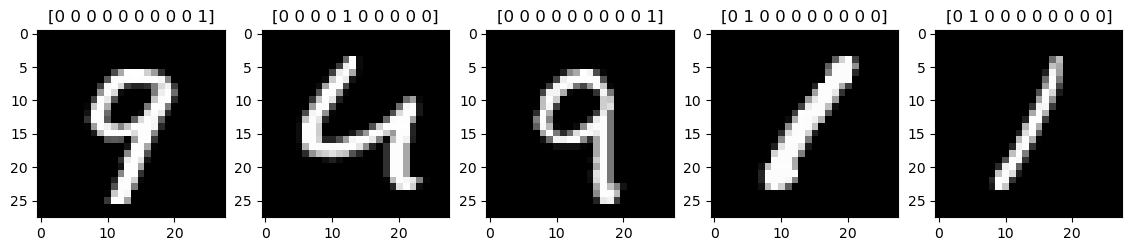

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(14, 5))
for i in range(0, 5): 
    axs[i].imshow(shuffled_images[i], cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(tf.cast(shuffled_labels[i], 'int32').numpy())

Since we are intersted in data scaling and do not need to gather telementry during training, we can just use 
```
model.fit(images, labels, epochs=10, batch_size=32)
```

and later on use 

```
model.evaluate(test_images, test_labels)
```

to collect necessary telemetry for different datataset sizes. You can adapt the code from  [01_scaling_laws_on_minst_data.ipynb]('./tutorials/data-scaling/01_scaling_laws_on_minst_data.ipynb') to solve the following exercises. 

# Homework

## 1.1. Empirical data scaling laws for MNIST dataset (<font color='red'>1p</font>)

Tabulate test accuracy for softmax regression model (aka perceptron) and LeNet-5 on dataset sizes $6000, 12000,\ldots, 60000$.
To eyeball the effect of random fluctuations. Perform the experiment twice with different randomisations. Draw the corresponding scaling laws as two graphs with two lines on each. 

## 1.2. The impact of training set on the empirical data scaling law (<font color='red'>1p</font>)

To elliminate the impact of test set fluctuations generate a syntetic test set using the image generatof from the tutorial [02_relative_accuracy_estimation.ipynb]('./tutorials/data-scaling/02_relative_accuracy_estimation.ipynb). You need the raw generator `generate_samples`. To generate the test set with it you need to fix sample sizes for all classes. Do it in a manner that you have 100,000 samples. Rerun the experiment from Exercise 1.1 so that there are at least to different runs. Draw the corresponding scaling laws for one model. Think how you should visualise the fluctuations and what should be the accuracy values for line-graph. 



## 1.3. Scaling law with refined precision using relative performance evaluation (<font color='red'>1p</font>)

Exercise 1.2 used a really big testset to squash corresponding fluctuations. This is not practical use the relative performance estimation metod form tutorial [02_relative_accuracy_estimation]('./tutorials/data-scaling/02_relative_accuracy_estimation.ipynb) to find relative differences in accuracies. Again, you can assume that you have 100,000 element test set but now it is unlabelled. Use the budget of $10,000$ labes to compute enough performance differences to recover the shape of the graph. A corresponding scaling laws for one model and single run is enough.  


## 1.4. Evaluation of precision-recall graphs as a function of training set size (<font color='red'>1p</font>)

Use the training sets from Exercise 1.1 to train to models. Compute the corrsponding precision-recall graphs for LeNet-5 model and draw them on the same graph. Note that these graphs make sense only for binary classification. Thus you need to cast the problem back to binary classification. For that choose the label `8` as the positive class and merge all other classes to negative class. You can train binary classification models or extract the score corresponding to the label `8` and pass it to `sklearn.metrics.precision_recall_curve`. Interpret the image you get.

## 1.5 How randomness impacts performnce$^*$ (<font color='red'>3p</font>)

There are three sources of randomness that cause fluctuations at measured test error: 
* randomness in model training
* randomness in training set sampling
* randomness in test set sampling

Use the image generatof from the tutorial [02_relative_accuracy_estimation.ipynb]('./tutorials/data-scaling/02_relative_accuracy_estimation.ipynb) to study this. 
By design all three sources of randomness are uncorrelated. However, this does not mean that we can split the variance into three separate components. Fix two components and extimate the residual variance of accuracy. In particular, fix training set size, number of epochs and test set size in your study. Try to prove that variance due to training randomness is roughrly the same regardless of the traing and test set choices and so on. Draw some visualisations and interpret results.     

